The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6


# Sequence Models

:label:`sec_sequence`


Imagine that you are watching movies on Netflix. As a good Netflix user, you decide to rate each of the movies religiously. After all, a good movie is a good movie, and you want to watch more of them, right? As it turns out, things are not quite so simple. People's opinions on movies can change quite significantly over time. In fact, psychologists even have names for some of the effects:

* There is [anchoring](https://en.wikipedia.org/wiki/Anchoring), based on someone else's opinion. For instance after the Oscar awards, ratings for the corresponding movie go up, even though it is still the same movie. This effect persists for a few months until the award is forgotten. :cite:`Wu.Ahmed.Beutel.ea.2017` showed that the effect lifts rating by over half a point.
* There is the [Hedonic adaptation](https://en.wikipedia.org/wiki/Hedonic_treadmill), where humans quickly adapt to accept an improved (or a bad) situation as the new normal. For instance, after watching many good movies, the expectations that the next movie is equally good or better are high, hence even an average movie might be considered a bad movie after many great ones.
* There is seasonality. Very few viewers like to watch a Santa Claus movie in August.
* In some cases movies become unpopular due to the misbehaviors of directors or actors in the production.
* Some movies become cult movies, because they were almost comically bad. *Plan 9 from Outer Space* and *Troll 2* achieved a high degree of notoriety for this reason.

In short, ratings are anything but stationary. Using temporal dynamics helped :cite:`Koren.2009` to recommend
movies more accurately. But it is not just about movies.

* Many users have highly particular behavior when it comes to the time when they open apps. For instance, social media apps are much more popular after school with students. Stock market trading apps are more commonly used when the markets are open.
* It is much harder to predict tomorrow's stock prices than to fill in the blanks for a stock price we missed yesterday, even though both are just a matter of estimating one number. After all, hindsight is so much easier than foresight. In statistics the former is called *extrapolation* whereas the latter is called *interpolation*.
* Music, speech, text, movies, steps, etc. are all sequential in nature. If we were to permute them they would make little sense. The headline *dog bites man* is much less surprising than *man bites dog*, even though the words are identical.
* Earthquakes are strongly correlated, i.e., after a massive earthquake there are very likely several smaller aftershocks, much more so than without the strong quake. In fact, earthquakes are spatiotemporally correlated, i.e., the aftershocks typically occur within a short time span and in close proximity.
* Humans interact with each other in a sequential nature, as can be seen in Twitter fights, dance patterns and debates.

## Statistical Tools

In short, we need statistical tools and new deep neural networks architectures to deal with sequence data. To keep things simple, we use the stock price illustrated in :numref:`fig_ftse100` as an example.

![FTSE 100 index over 30 years](../img/ftse100.png)

:width:`400px`


:label:`fig_ftse100`


Let us denote the prices by $x_t \geq 0$, i.e., at time $t \in \mathbb{N}$ we observe some price $x_t$. For a trader to do well in the stock market on day $t$ he should want to predict $x_t$ via

$$x_t \sim p(x_t \mid x_{t-1}, \ldots, x_1).$$

### Autoregressive Models

In order to achieve this, our trader could use a regressor such as the one we trained in :numref:`sec_linear_gluon`. There is just a major problem: the number of inputs, $x_{t-1}, \ldots, x_1$ varies, depending on $t$. That is, the number increases with the amount of data that we encounter, and we will need an approximation to make this computationally tractable. Much of what follows in this chapter will revolve around how to estimate $p(x_t \mid x_{t-1}, \ldots, x_1)$ efficiently. In a nutshell it boils down to two strategies:

1. Assume that the potentially rather long sequence $x_{t-1}, \ldots, x_1$ is not really necessary. In this case we might content ourselves with some timespan $\tau$ and only use $x_{t-1}, \ldots, x_{t-\tau}$ observations. The immediate benefit is that now the number of arguments is always the same, at least for $t > \tau$. This allows us to train a deep network as indicated above. Such models will be called *autoregressive* models, as they quite literally perform regression on themselves.
1. Another strategy, shown in :numref:`fig_sequence-model`, is to try and keep some summary $h_t$ of the past observations, at the same time update $h_t$ in addition to the prediction $\hat{x_t}$. This leads to models that estimate $x_t$ with $\hat{x_t} = p(x_t \mid x_{t-1}, h_{t})$ and moreover updates of the form  $h_t = g(h_{t-1}, x_{t-1})$. Since $h_t$ is never observed, these models are also called *latent autoregressive models*. LSTMs and GRUs are examples of this.

![A latent autoregressive model. ](../img/sequence-model.svg)

:label:`fig_sequence-model`


Both cases raise the obvious question of how to generate training data. One typically uses historical observations to predict the next observation given the ones up to right now. Obviously we do not expect time to stand still. However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the time series itself will not. This is reasonable, since novel dynamics are just that, novel and thus not predictable using data that we have so far. Statisticians call dynamics that do not change *stationary*. Regardless of what we do, we will thus get an estimate of the entire time series via

$$p(x_1, \ldots, x_T) = \prod_{t=1}^T p(x_t \mid x_{t-1}, \ldots, x_1).$$

Note that the above considerations still hold if we deal with discrete objects, such as words, rather than numbers. The only difference is that in such a situation we need to use a classifier rather than a regressor to estimate $p(x_t \mid  x_{t-1}, \ldots, x_1)$.

### Markov Model

Recall the approximation that in an autoregressive model we use only $(x_{t-1}, \ldots, x_{t-\tau})$ instead of $(x_{t-1}, \ldots, x_1)$ to estimate $x_t$. Whenever this approximation is accurate we say that the sequence satisfies a *Markov condition*. In particular, if $\tau = 1$, we have a *first order* Markov model and $p(x)$ is given by

$$p(x_1, \ldots, x_T) = \prod_{t=1}^T p(x_t \mid x_{t-1}).$$

Such models are particularly nice whenever $x_t$ assumes only a discrete value, since in this case dynamic programming can be used to compute values along the chain exactly. For instance, we can compute $p(x_{t+1} \mid x_{t-1})$ efficiently using the fact that we only need to take into account a very short history of past observations:

$$p(x_{t+1} \mid x_{t-1}) = \sum_{x_t} p(x_{t+1} \mid x_t) p(x_t \mid x_{t-1}).$$


Going into details of dynamic programming is beyond the scope of this section, but we will introduce it in :numref:`sec_bi_rnn`. Control and reinforcement learning algorithms use such tools extensively.

### Causality

In principle, there is nothing wrong with unfolding $p(x_1, \ldots, x_T)$ in reverse order. After all, by conditioning we can always write it via

$$p(x_1, \ldots, x_T) = \prod_{t=T}^1 p(x_t \mid x_{t+1}, \ldots, x_T).$$

In fact, if we have a Markov model, we can obtain a reverse conditional probability distribution, too. In many cases, however, there exists a natural direction for the data, namely going forward in time. It is clear that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. That is, if we change $x_t$, the distribution over past events will not change. Consequently, it ought to be easier to explain $p(x_{t+1} \mid x_t)$ rather than $p(x_t \mid x_{t+1})$. For instance, :cite:`Hoyer.Janzing.Mooij.ea.2009` show that in some cases we can find $x_{t+1} = f(x_t) + \epsilon$ for some additive noise, whereas the converse is not true. This is great news, since it is typically the forward direction that we are interested in estimating. For more on this topic see e.g., the book by :cite:`Peters.Janzing.Scholkopf.2017`. We are barely scratching the surface of it.

## A Toy Example

After so much theory, let us try this out in practice. Let us begin by generating some data. To keep things simple we generate our time series by using a sine function with some additive noise.

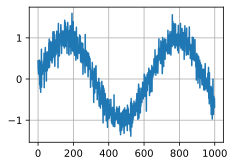

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import nn
npx.set_np()

T = 1000  # Generate a total of 1000 points
time = np.arange(0, T)
x = np.sin(0.01 * time) + 0.2 * np.random.normal(size=T)
d2l.plot(time, [x])

Next we need to turn this time series into features and labels that the network can train on. Based on the embedding dimension $\tau$ we map the data into pairs $y_t = x_t$ and $\mathbf{z}_t = (x_{t-1}, \ldots, x_{t-\tau})$. The astute reader might have noticed that this gives us $\tau$ fewer data points, since we do not have sufficient history for the first $\tau$ of them. A simple fix, in particular if the time series is long is to discard those few terms. Alternatively we could pad the time series with zeros. The code below is essentially identical to the training code in previous sections. We kept the architecture fairly simple. A few layers of a fully connected network, ReLU activation and $\ell_2$ loss. Since much of the modeling is identical to the previous sections when we built regression estimators in Gluon, we will not delve into much detail.

In [2]:
tau = 4
features = np.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i: T-tau+i]
labels = x[tau:]

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)
test_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                           batch_size, is_train=False)

# Vanilla MLP architecture
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize(init.Xavier())
    return net

# Least mean squares loss
loss = gluon.loss.L2Loss()

Now we are ready to train.

In [3]:
def train_net(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(1, epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print('epoch %d, loss: %f' % (
            epoch, d2l.evaluate_loss(net, train_iter, loss)))

net = get_net()
train_net(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.034483
epoch 2, loss: 0.030008


epoch 3, loss: 0.028078
epoch 4, loss: 0.028386


epoch 5, loss: 0.026753
epoch 6, loss: 0.026750


epoch 7, loss: 0.026075
epoch 8, loss: 0.026098


epoch 9, loss: 0.025403
epoch 10, loss: 0.026016


## Predictions

Since both training and test loss are small, we would expect our model to work well. Let us see what this means in practice. The first thing to check is how well the model is able to predict what happens in the next timestep.

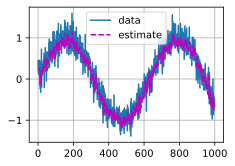

In [4]:
estimates = net(features)
d2l.plot([time, time[tau:]], [x, estimates],
         legend=['data', 'estimate'])

This looks nice, just as we expected it. Even beyond 600 observations the estimates still look rather trustworthy. There is just one little problem to this: if we observe data only until timestep 600, we cannot hope to receive the ground truth for all future predictions. Instead, we need to work our way forward one step at a time:

$$\begin{aligned}
x_{601} & = f(x_{600}, \ldots, x_{597}), \\
x_{602} & = f(x_{601}, \ldots, x_{598}), \\
x_{603} & = f(x_{602}, \ldots, x_{599}).
\end{aligned}$$

In other words, we will have to use our own predictions to make future predictions. Let us see how well this goes.

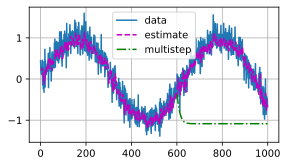

In [5]:
predictions = np.zeros(T)
predictions[:n_train] = x[:n_train]
for i in range(n_train, T):
    predictions[i] = net(
        predictions[(i-tau):i].reshape(1, -1)).reshape(1)
d2l.plot([time, time[tau:], time[n_train:]],
         [x, estimates, predictions[n_train:]],
         legend=['data', 'estimate', 'multistep'], figsize=(4.5, 2.5))

As the above example shows, this is a spectacular failure. The estimates decay to a constant pretty quickly after a few prediction steps. Why did the algorithm work so poorly? This is ultimately due to the fact that the errors build up. Let us say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$. Now the *input* for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + L \epsilon_1$, and so on. The error can diverge rather rapidly from the true observations. This is a common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate but beyond that the accuracy declines rapidly. We will discuss methods for improving this throughout this chapter and beyond.

Let us verify this observation by computing the $k$-step predictions on the entire sequence.

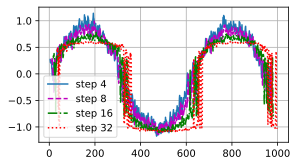

In [6]:
k = 33  # Look up to k - tau steps ahead

features = np.zeros((k, T-k))
for i in range(tau):  # Copy the first tau features from x
    features[i] = x[i:T-k+i]

for i in range(tau, k):  # Predict the (i-tau)-th step
    features[i] = net(features[(i-tau):i].T).T

steps = (4, 8, 16, 32)
d2l.plot([time[i:T-k+i] for i in steps], [features[i] for i in steps],
         legend=['step %d' % i for i in steps], figsize=(4.5, 2.5))

This clearly illustrates how the quality of the estimates changes as we try to predict further into the future. While the 8-step predictions are still pretty good, anything beyond that is pretty useless.


## Summary

* Sequence models require specialized statistical tools for estimation. Two popular choices are autoregressive models and latent-variable autoregressive models.
* As we predict further in time, the errors accumulate and the quality of the estimates degrades, often dramatically.
* There is quite a difference in difficulty between interpolation and extrapolation. Consequently, if you have a time series, always respect the temporal order of the data when training, i.e., never train on future data.
* For causal models (e.g., time going forward), estimating the forward direction is typically a lot easier than the reverse direction.


## Exercises

1. Improve the above model.
    * Incorporate more than the past 4 observations? How many do you really need?
    * How many would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.
    * Can you incorporate older features while keeping the total number of features constant? Does this improve accuracy? Why?
    * Change the neural network architecture and see what happens.
1. An investor wants to find a good security to buy. She looks at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?
1. Does causality also apply to text? To which extent?
1. Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.

## [Discussions](https://discuss.mxnet.io/t/2860)

![](http://d2l.ai/_images/qr_sequence.svg)